# Cognitive Robotics Project: Human Gaze Perception

## Experiment 1: Gaze perception based on pupils only

### Step 1. Generate data

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set parameters
gaze_directions = [-9, -6, -3, 0, 3, 6, 9]
noise_levels = {
    "low": 1,
    "medium": 3,
    "high": 6
}

n_samples_per_combination = 100

# Generate data
data = []

for gaze in gaze_directions:
    for noise_label, noise_std in noise_levels.items():
        for _ in range(n_samples_per_combination):
            noisy_gaze = np.random.normal(loc=gaze, scale=noise_std)
            
            # Perceived orientation: human tendency to think gaze is towards them
            # "towards" is if noisy gaze is  between -2 and +2 degrees
            observed_orientation = "towards" if abs(noisy_gaze) <= 2 else "away"
            
            data.append({
                "true_gaze": gaze,
                "noise_level": noise_label,
                "noisy_gaze": noisy_gaze,
                "observed_orientation": observed_orientation
            })

df = pd.DataFrame(data)

In [6]:
df

,true_gaze,noise_level,noisy_gaze,observed_orientation
0,-9,low,-10.540670,away
1,-9,low,-8.169469,away
2,-9,low,-9.350173,away
3,-9,low,-10.925643,away
4,-9,low,-9.061334,away
...,...,...,...,...
2095,9,high,11.204801,away
2096,9,high,17.811203,away
2097,9,high,8.100075,away
2098,9,high,7.700104,away


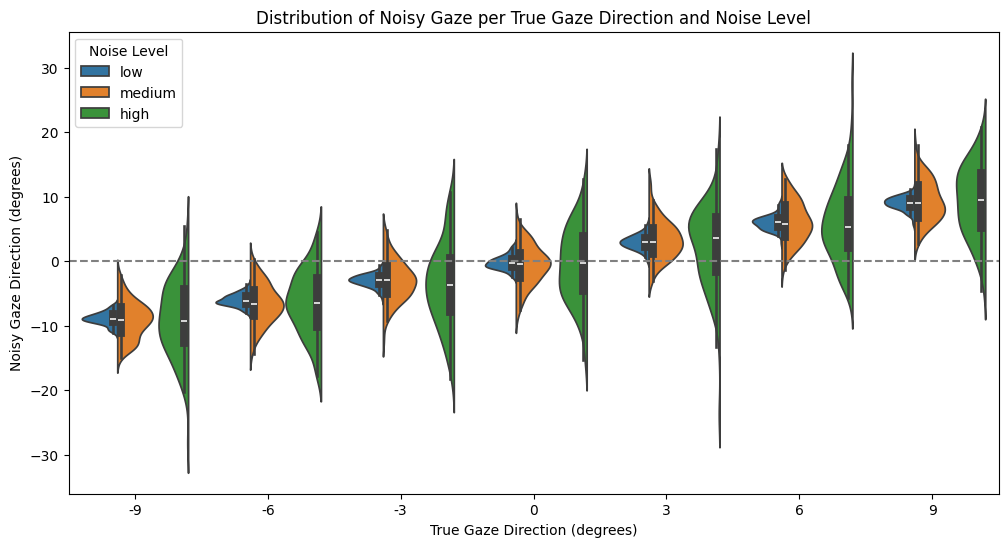

In [8]:
plt.figure(figsize=(12, 6))
sns.violinplot(data=df, x="true_gaze", y="noisy_gaze", hue="noise_level", split=True)
plt.axhline(0, color='gray', linestyle='--')
plt.title("Distribution of Noisy Gaze per True Gaze Direction and Noise Level")
plt.ylabel("Noisy Gaze Direction (degrees)")
plt.xlabel("True Gaze Direction (degrees)")
plt.legend(title="Noise Level")
plt.show()

### Step 2: Define Perception Probabilities

In [10]:
# Define probability lookup
bias_probs = {
    "low":    {"towards": [0.9, 0.1], "away": [0.3, 0.7]},
    "medium": {"towards": [0.95, 0.05], "away": [0.5, 0.5]},
    "high":   {"towards": [0.98, 0.02], "away": [0.7, 0.3]}
}

# Sample perceived gaze based on noise + observed orientation
def simulate_perception(row):
    probs = bias_probs[row["noise_level"]][row["observed_orientation"]]
    return np.random.choice(["towards", "away"], p=probs)

df["perceived_gaze"] = df.apply(simulate_perception, axis=1)

In [11]:
df

,true_gaze,noise_level,noisy_gaze,observed_orientation,perceived_gaze
0,-9,low,-10.342641,away,away
1,-9,low,-9.402951,away,away
2,-9,low,-9.315133,away,away
3,-9,low,-9.284000,away,away
4,-9,low,-8.731709,away,away
...,...,...,...,...,...
2095,9,high,11.635192,away,away
2096,9,high,11.826858,away,towards
2097,9,high,3.612939,away,towards
2098,9,high,7.031457,away,towards


### Step 3: Train Bayesian Network

In [15]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import ParameterEstimator, MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Define structure: perceived_gaze depends on observed_orientation and noise_level
model = DiscreteBayesianNetwork([
    ("observed_orientation", "perceived_gaze"),
    ("noise_level", "perceived_gaze")
])

# Fit the model
model.fit(df, estimator=MaximumLikelihoodEstimator)

# Inference
inference = VariableElimination(model)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'true_gaze': 'N', 'noise_level': 'C', 'noisy_gaze': 'N', 'observed_orientation': 'C', 'perceived_gaze': 'C'}


### Step 4: Visualize Results

In [23]:
for noise in ["low", "medium", "high"]:
    q = inference.query(variables=["perceived_gaze"], evidence={"observed_orientation": "away", "noise_level": noise})
    print(f"Noise: {noise}")
    print(q)

Noise: low
+-------------------------+-----------------------+
| perceived_gaze          |   phi(perceived_gaze) |
+=========================+=======================+
| perceived_gaze(away)    |                0.6832 |
+-------------------------+-----------------------+
| perceived_gaze(towards) |                0.3168 |
+-------------------------+-----------------------+
Noise: medium
+-------------------------+-----------------------+
| perceived_gaze          |   phi(perceived_gaze) |
+=========================+=======================+
| perceived_gaze(away)    |                0.4857 |
+-------------------------+-----------------------+
| perceived_gaze(towards) |                0.5143 |
+-------------------------+-----------------------+
Noise: high
+-------------------------+-----------------------+
| perceived_gaze          |   phi(perceived_gaze) |
+=========================+=======================+
| perceived_gaze(away)    |                0.3117 |
+-------------------------+

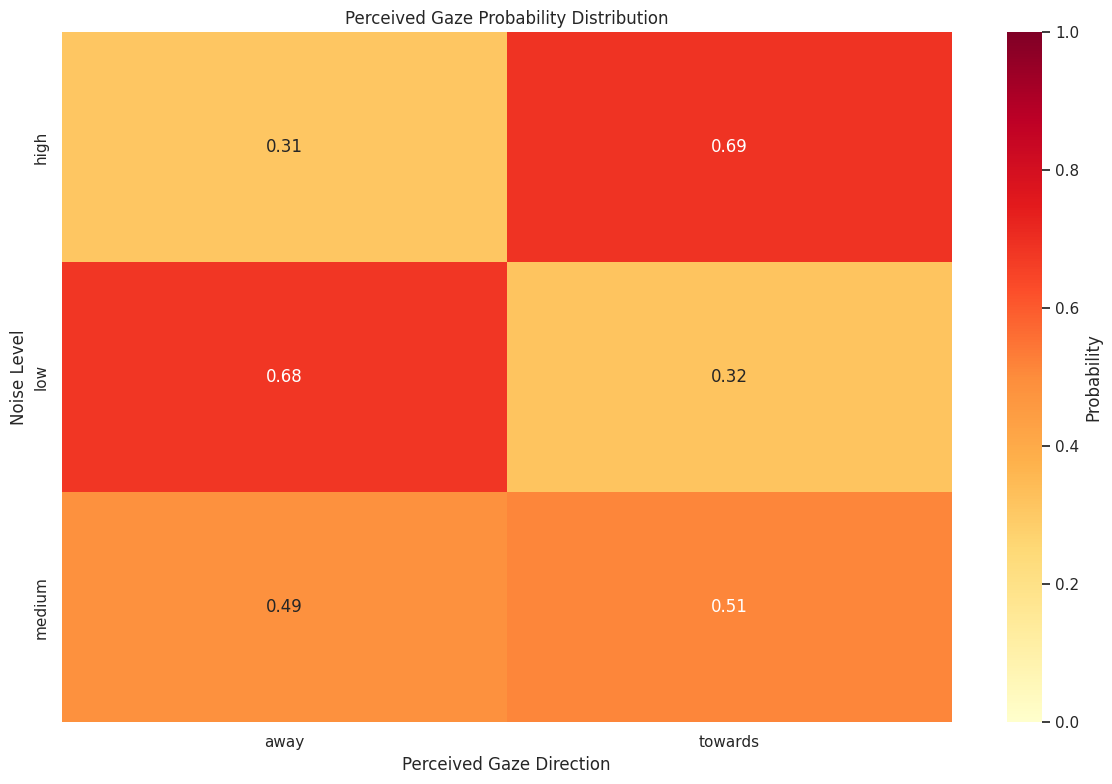

In [68]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

observed_states = model.get_cpds("observed_orientation").state_names["observed_orientation"]
noise_states = model.get_cpds("noise_level").state_names["noise_level"]
gaze_states = model.get_cpds("perceived_gaze").state_names["perceived_gaze"]

results = []

for obs in observed_states:
    for noise in noise_states:
        q = inference.query(variables=["perceived_gaze"], 
                          evidence={"observed_orientation": obs, "noise_level": noise})
        for gaze in gaze_states:
            results.append({
                "observed_orientation": obs,
                "noise_level": noise,
                "perceived_gaze": gaze,
                "probability": q.values[gaze_states.index(gaze)]
            })

results_df = pd.DataFrame(results)

heatmap_data = results_df.pivot_table(index="noise_level", 
                                     columns="perceived_gaze", 
                                     values="probability",
                                     aggfunc='first')

plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="YlOrRd", 
            cbar_kws={'label': 'Probability'}, vmin=0, vmax=1)
plt.title("Perceived Gaze Probability Distribution")
plt.xlabel("Perceived Gaze Direction")
plt.ylabel("Noise Level")
plt.tight_layout()
plt.show()

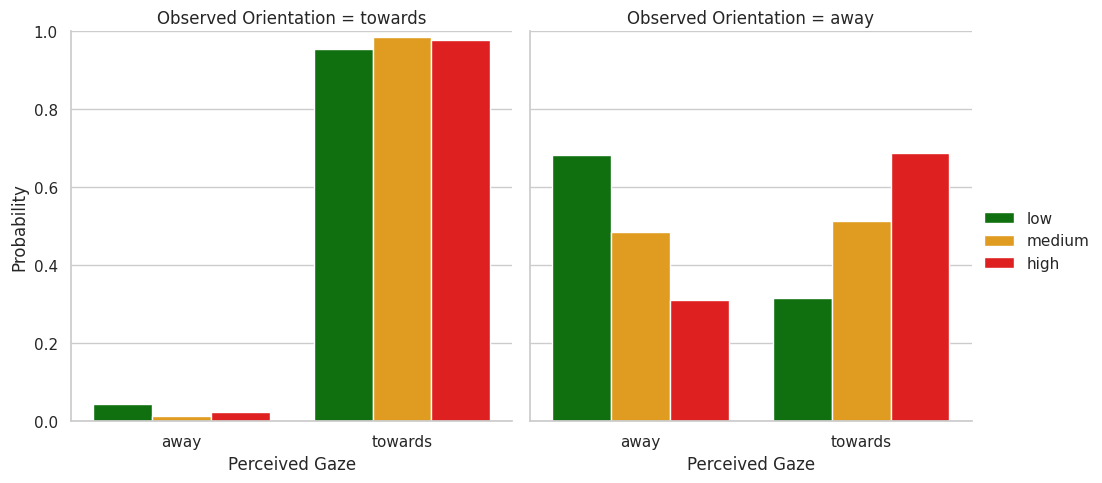

In [26]:
results = []
for orientation in ["towards", "away"]:
    for noise in ["low", "medium", "high"]:
        q = inference.query(variables=["perceived_gaze"], 
                           evidence={"observed_orientation": orientation, "noise_level": noise})
        states = q.state_names["perceived_gaze"]
        for state, prob in zip(states, q.values.ravel()):
            results.append({
                "Observed Orientation": orientation,
                "Noise Level": noise,
                "Perceived Gaze": state,
                "Probability": prob
            })

results_df = pd.DataFrame(results)

g = sns.FacetGrid(results_df, col="Observed Orientation", height=5, aspect=1)
g.map_dataframe(sns.barplot, x="Perceived Gaze", y="Probability", hue="Noise Level",
               palette={"low": "green", "medium": "orange", "high": "red"})
g.add_legend()
g.set_titles("Observed Orientation = {col_name}")
g.set(ylim=(0, 1))
plt.show()

## Experiment 2: Gaze perception based on pupils and face orientation

### Step 1: Generate Data

In [29]:
# Simulate extended data
extended_data = []

for gaze in gaze_directions:
    for noise_label, noise_std in noise_levels.items():
        for head in [-30, -15, -5, 0, 5, 15, 30]:
            head_orientation = "towards" if abs(head) <= 5 else "away"
            for _ in range(n_samples_per_combination // 3):  # Reduce count for speed
                noisy_gaze = np.random.normal(loc=gaze, scale=noise_std)
                pupil_orientation = "towards" if abs(noisy_gaze) <= 2 else "away"
                
                # Add human bias (stronger when noise is high and head is towards)
                base_probs = {
                    "low":    {"towards": [0.9, 0.1], "away": [0.3, 0.7]},
                    "medium": {"towards": [0.95, 0.05], "away": [0.5, 0.5]},
                    "high":   {"towards": [0.98, 0.02], "away": [0.7, 0.3]}
                }

                # Influence from head: slightly tilt towards "towards" if head is facing forward
                probs = base_probs[noise_label][pupil_orientation]
                if head_orientation == "towards":
                    probs = [min(1.0, probs[0] + 0.1), max(0.0, probs[1] - 0.1)]
                else:
                    probs = [max(0.0, probs[0] - 0.1), min(1.0, probs[1] + 0.1)]

                perceived_gaze = np.random.choice(["towards", "away"], p=probs)

                extended_data.append({
                    "true_gaze": gaze,
                    "noise_level": noise_label,
                    "noisy_gaze": noisy_gaze,
                    "pupil_orientation": pupil_orientation,
                    "head_orientation": head_orientation,
                    "perceived_gaze": perceived_gaze
                })

df_ext = pd.DataFrame(extended_data)

In [30]:
df_ext

,true_gaze,noise_level,noisy_gaze,pupil_orientation,head_orientation,perceived_gaze
0,-9,low,-7.729346,away,away,away
1,-9,low,-10.001675,away,away,away
2,-9,low,-9.280280,away,away,away
3,-9,low,-8.832693,away,away,towards
4,-9,low,-7.890803,away,away,away
...,...,...,...,...,...,...
4846,9,high,4.929327,away,away,towards
4847,9,high,5.035135,away,away,away
4848,9,high,2.749691,away,away,away
4849,9,high,16.672883,away,away,towards


### Step 2: Train Bayesian Network:

In [33]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

# Define structure
model_ext = DiscreteBayesianNetwork([
    ("pupil_orientation", "perceived_gaze"),
    ("head_orientation", "perceived_gaze"),
    ("noise_level", "perceived_gaze")
])

# Fit model
model_ext.fit(df_ext, estimator=MaximumLikelihoodEstimator)
inference_ext = VariableElimination(model_ext)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'true_gaze': 'N', 'noise_level': 'C', 'noisy_gaze': 'N', 'pupil_orientation': 'C', 'head_orientation': 'C', 'perceived_gaze': 'C'}


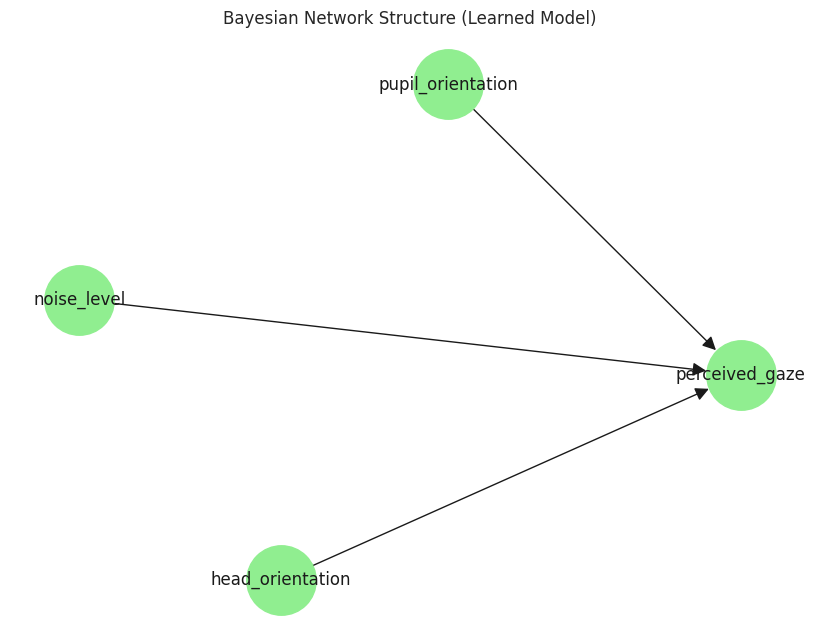

In [76]:
import networkx as nx
import matplotlib.pyplot as plt

edges = model_ext.edges()

G = nx.DiGraph()
G.add_edges_from(edges)

plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color="lightgreen", node_size=2500, font_size=12, arrowsize=20)
plt.title("Bayesian Network Structure (Learned Model)")
plt.show()

### Step 3: Visualizse Results

<Figure size 1400x1000 with 0 Axes>

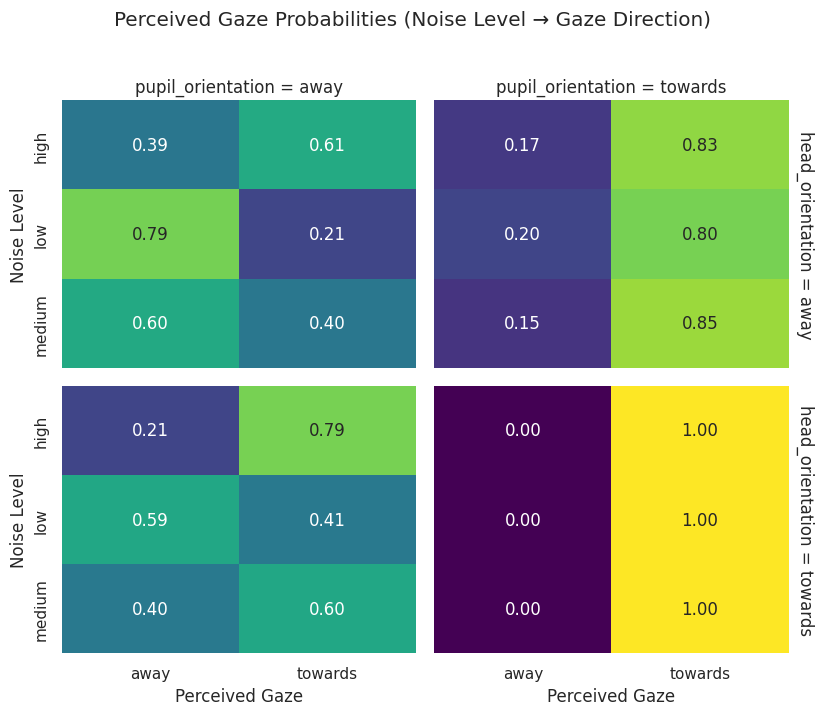

In [73]:
plt.figure(figsize=(14, 10))
g = sns.FacetGrid(results_df, 
                 row="head_orientation",
                 col="pupil_orientation",
                 margin_titles=True,
                 height=3.5,
                 aspect=1.2)

def draw_heatmap(data, **kwargs):
    pivot_data = data.pivot_table(index="noise_level",
                                columns="perceived_gaze",
                                values="probability")
    sns.heatmap(pivot_data, 
               annot=True, 
               fmt=".2f", 
               cmap="viridis",
               cbar=False,  # Explicitly disable colorbar
               vmin=0, 
               vmax=1,
               **kwargs)

g.map_dataframe(draw_heatmap)

# Adjust labels and titles
g.set_axis_labels("Perceived Gaze", "Noise Level")
g.set_titles("Head: {row_name} | Pupil: {col_name}")
plt.suptitle("Perceived Gaze Probabilities (Noise Level → Gaze Direction)", y=1.02)
plt.tight_layout()
plt.show()

In [35]:
results = []

for noise in ["low", "medium", "high"]:
    for head in ["towards", "away"]:
        for pupil in ["towards", "away"]:
            q = inference_ext.query(variables=["perceived_gaze"], evidence={
                "pupil_orientation": pupil,
                "head_orientation": head,
                "noise_level": noise
            })
            prob_towards = q.values[1]
            results.append({
                "noise_level": noise,
                "head_orientation": head,
                "pupil_orientation": pupil,
                "P(perceived='towards')": prob_towards
            })

df_results = pd.DataFrame(results)

In [36]:
df_results

,noise_level,head_orientation,pupil_orientation,P(perceived='towards')
0,low,towards,towards,1.000000
1,low,towards,away,0.405872
2,low,away,towards,0.796407
3,low,away,away,0.210040
4,medium,towards,towards,1.000000
5,medium,towards,away,0.596460
6,medium,away,towards,0.849162
7,medium,away,away,0.397315
8,high,towards,towards,1.000000
9,high,towards,away,0.794690


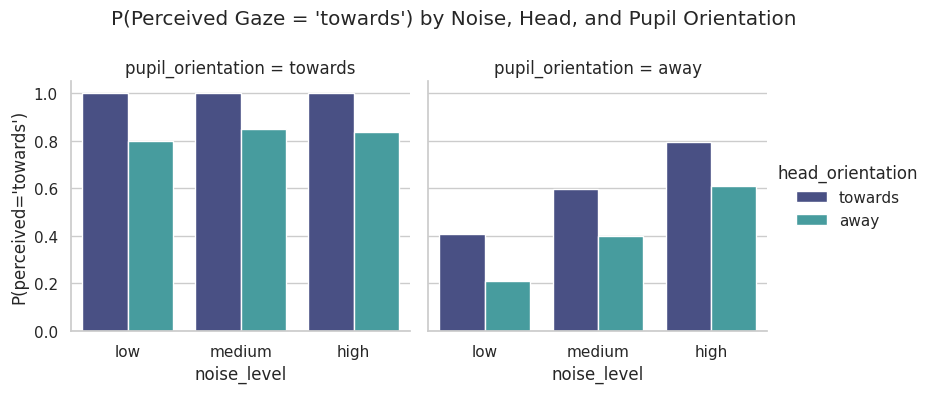

<Figure size 1500x800 with 0 Axes>

In [62]:
g = sns.catplot(
    data=df_results,
    x="noise_level", y="P(perceived='towards')",
    hue="head_orientation", col="pupil_orientation",
    kind="bar", height=4, aspect=1, palette="mako"
)
plt.figure(figsize=(15, 8))
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle("P(Perceived Gaze = 'towards') by Noise, Head, and Pupil Orientation")
plt.show()

## Comparing models

In [39]:
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.estimators import MaximumLikelihoodEstimator
from pgmpy.inference import VariableElimination

model_a = DiscreteBayesianNetwork([
    ("pupil_orientation", "perceived_gaze"),
    ("noise_level", "perceived_gaze")
])

model_a.fit(df_ext, estimator=MaximumLikelihoodEstimator)
inference_a = VariableElimination(model_a)

model_b = DiscreteBayesianNetwork([
    ("pupil_orientation", "perceived_gaze"),
    ("noise_level", "perceived_gaze"),
    ("head_orientation", "perceived_gaze")
])

model_b.fit(df_ext, estimator=MaximumLikelihoodEstimator)
inference_b = VariableElimination(model_b)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'true_gaze': 'N', 'noise_level': 'C', 'noisy_gaze': 'N', 'pupil_orientation': 'C', 'head_orientation': 'C', 'perceived_gaze': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'true_gaze': 'N', 'noise_level': 'C', 'noisy_gaze': 'N', 'pupil_orientation': 'C', 'head_orientation': 'C', 'perceived_gaze': 'C'}


In [40]:
comparison_results = []

for noise in ["low", "medium", "high"]:
    for pupil in ["towards", "away"]:
        for head in ["towards", "away"]:
            # Model A: without head_orientation
            q_a = inference_a.query(variables=["perceived_gaze"], evidence={
                "pupil_orientation": pupil,
                "noise_level": noise
            })
            prob_a = q_a.values[1]

            # Model B: with head_orientation
            q_b = inference_b.query(variables=["perceived_gaze"], evidence={
                "pupil_orientation": pupil,
                "noise_level": noise,
                "head_orientation": head
            })
            prob_b = q_b.values[1]

            comparison_results.append({
                "noise_level": noise,
                "pupil_orientation": pupil,
                "head_orientation": head,
                "P_towards_Model_A": prob_a,
                "P_towards_Model_B": prob_b,
                "delta": prob_b - prob_a
            })

df_compare = pd.DataFrame(comparison_results)

/tmp/ipykernel_260/3522207830.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


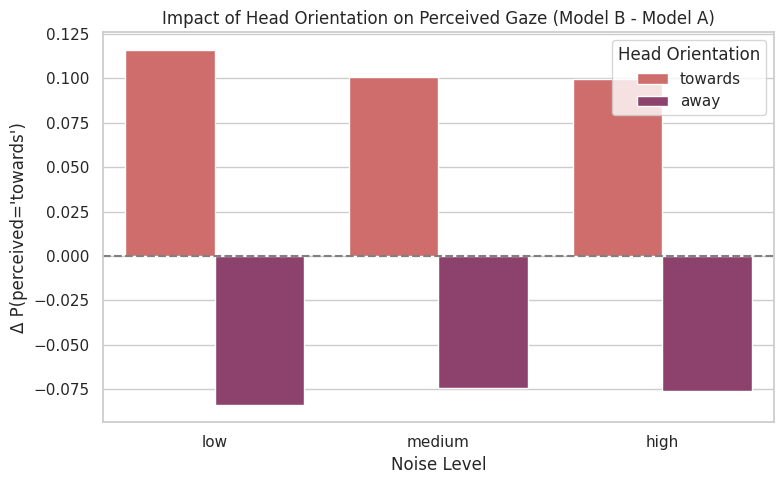

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
sns.barplot(
    data=df_compare,
    x="noise_level", y="delta", hue="head_orientation",
    ci=None, palette="flare"
)
plt.title("Impact of Head Orientation on Perceived Gaze (Model B - Model A)")
plt.ylabel("Δ P(perceived='towards')")
plt.xlabel("Noise Level")
plt.axhline(0, color='gray', linestyle='--')
plt.legend(title="Head Orientation")
plt.tight_layout()
plt.show()


In [50]:
from pgmpy.sampling import BayesianModelSampling

sampler = BayesianModelSampling(model_b)  # model_b = your DiscreteBayesianNetwork

evidence_settings = [
    {"pupil_orientation": "towards", "noise_level": "low", "head_orientation": "towards"},
    {"pupil_orientation": "away", "noise_level": "low", "head_orientation": "towards"},
    {"pupil_orientation": "away", "noise_level": "high", "head_orientation": "away"},
    {"pupil_orientation": "towards", "noise_level": "high", "head_orientation": "away"},
    {"pupil_orientation": "away", "noise_level": "high", "head_orientation": "towards"},
]
sample_results = []

for evidence in evidence_settings:
    print(f"Sampling for evidence: {evidence}")
    
    # Convert evidence dict to list of tuples
    evidence_tuples = list(evidence.items())

    # Draw samples
    samples = sampler.rejection_sample(
        evidence=evidence_tuples,
        size=1000
    )

    # Count how many are "towards" vs "away"
    counts = samples["perceived_gaze"].value_counts(normalize=True).to_dict()

    sample_results.append({
        **evidence,
        "P(perceived_gaze='towards')": counts.get("towards", 0),
        "P(perceived_gaze='away')": counts.get("away", 0)
    })

df_samples = pd.DataFrame(sample_results)


Sampling for evidence: {'pupil_orientation': 'towards', 'noise_level': 'low', 'head_orientation': 'towards'}





  0%|          | 0/1000 [00:00<?, ?it/s]


100%|██████████| 1000/1000 [00:00<00:00, 9321.46it/s]


Sampling for evidence: {'pupil_orientation': 'away', 'noise_level': 'low', 'head_orientation': 'towards'}





100%|██████████| 1000/1000 [00:00<00:00, 39136.56it/s]


Sampling for evidence: {'pupil_orientation': 'away', 'noise_level': 'high', 'head_orientation': 'away'}





100%|██████████| 1000/1000 [00:00<00:00, 54155.69it/s]


Sampling for evidence: {'pupil_orientation': 'towards', 'noise_level': 'high', 'head_orientation': 'away'}





100%|██████████| 1000/1000 [00:00<00:00, 15826.97it/s]


Sampling for evidence: {'pupil_orientation': 'away', 'noise_level': 'high', 'head_orientation': 'towards'}





100%|██████████| 1000/1000 [00:00<00:00, 41371.29it/s]


In [51]:
df_samples

,pupil_orientation,noise_level,head_orientation,P(perceived_gaze='towards'),P(perceived_gaze='away')
0,towards,low,towards,1.000,0.000
1,away,low,towards,0.402,0.598
2,away,high,away,0.615,0.385
3,towards,high,away,0.842,0.158
4,away,high,towards,0.801,0.199


/tmp/ipykernel_260/3916475792.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


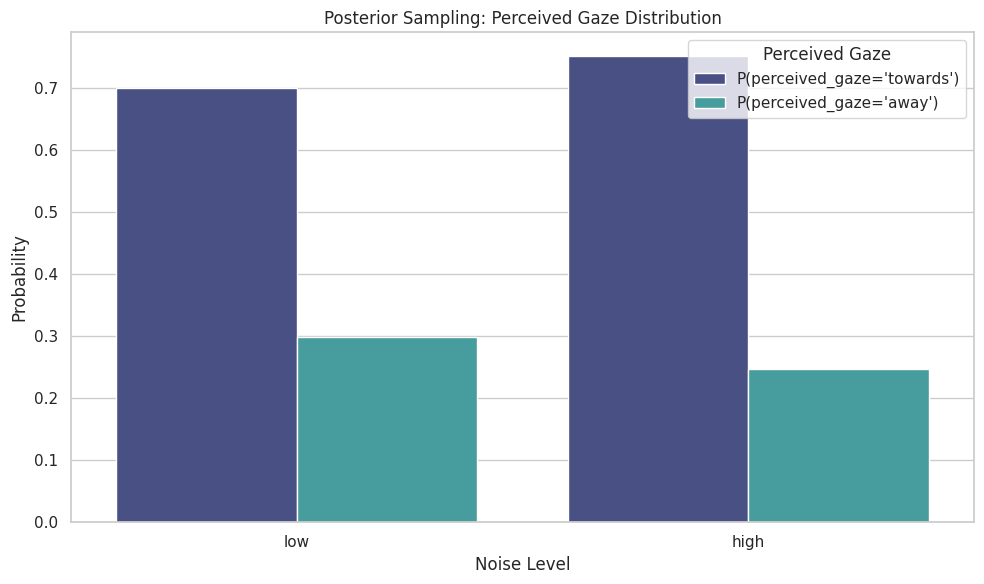

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Melt the dataframe to long format
df_plot = pd.melt(
    df_samples,
    id_vars=["pupil_orientation", "noise_level", "head_orientation"],
    value_vars=["P(perceived_gaze='towards')", "P(perceived_gaze='away')"],
    var_name="Perceived Gaze", value_name="Probability"
)

# Plot grouped bar plot
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_plot,
    x="noise_level", y="Probability", hue="Perceived Gaze",
    ci=None, palette="mako"
)
plt.title("Posterior Sampling: Perceived Gaze Distribution")
plt.xlabel("Noise Level")
plt.ylabel("Probability")
plt.legend(title="Perceived Gaze")
plt.tight_layout()
plt.show()